# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

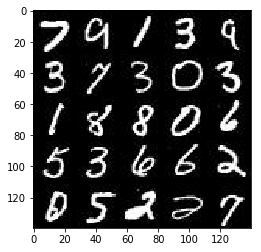

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

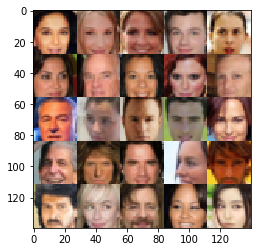

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels),name ="real_input") 
    z_input = tf.placeholder(tf.float32, shape=(None, z_dim),name ="z_input") 
    learning_rate = tf.placeholder(tf.float32, name ="learning_rate") 

    return real_input,z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [31]:
#improved relu
def lrelu(x, leak=0.2, name="lrelu"):
    f1 = 0.5 * (1 + leak)
    f2 = 0.5 * (1 - leak)
    return f1 * x + f2 * abs(x)

In [32]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    with tf.variable_scope('discriminator', reuse=reuse):        
        
        alpha = 0.2
        kern_i=tf.contrib.layers.xavier_initializer()
        # First fully connected layer
        h1 = tf.layers.conv2d(images, 64, 4, 2, 'same', use_bias=False, kernel_initializer=kern_i, activation=None)
        # Leaky ReLU
        h1 = lrelu(h1, leak=alpha)
        
        h2 = tf.layers.conv2d(h1, 128, 4, 2, 'same', use_bias=False,kernel_initializer=kern_i, activation=None)
        #batch norm
        h2 = tf.layers.batch_normalization(h2, training=True)
        # Leaky ReLU
        h2 = lrelu(h2, leak=alpha)
        
        h3 = tf.layers.conv2d(h1, 256, 4, 2, 'same', use_bias=False,kernel_initializer=kern_i, activation=None)
        #batch norm
        h3 = tf.layers.batch_normalization(h3, training=True)
        # Leaky ReLU
        h3 = lrelu(h3, leak=alpha)
        
        # Flatten it
        flat = tf.contrib.layers.flatten(h3)
        logits = tf.layers.dense(flat, 1, kernel_initializer=kern_i)
        output = tf.sigmoid(logits)
        
        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [41]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        kern_i=tf.contrib.layers.xavier_initializer()
        # First fully connected layer
        h1 = tf.layers.dense(z,7*7*512, activation = None, kernel_initializer=kern_i)
        #batch norm
        h1 = tf.reshape(h1, (-1, 7, 7, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        # Leaky ReLU
        h1 = lrelu(h1, leak=alpha)
        
        h2 = tf.layers.conv2d_transpose(h1, 200, 4, 2, 'same', use_bias=False, kernel_initializer=kern_i, activation=None)
        #batch norm
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        # Leaky ReLU
        h2 = lrelu(h2, leak=alpha)
        
        h22 = tf.layers.conv2d_transpose(h2, 64, 4, 1, 'same', kernel_initializer=kern_i, use_bias=False, activation=None)
        #batch norm
        h22 = tf.layers.batch_normalization(h22, training=is_train)
        # Leaky ReLU
        h22 = lrelu(h22, leak=alpha)
        
        h3 = tf.layers.conv2d_transpose(h22, 3, 4, 2, 'same', use_bias=False, kernel_initializer=kern_i, activation=None)
        #batch norm
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        # Leaky ReLU
        h3 = lrelu(h3, leak=alpha)
        
        # Logits and tanh output
        logits = tf.layers.dense(h3,out_channel_dim, activation = None)
        
        output = tf.tanh(logits)
        
        return output

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [42]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    alpha = 0.2
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    smooth = 0.1

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)*(smooth)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [43]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_op = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_op = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_op, g_train_op


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [44]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [45]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    tf.reset_default_graph()

    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_opt, feed_dict={input_real: batch_images*2, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                if steps % 10 == 0:
                    # Print after 100
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 15, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.3372... Generator Loss: 8.1040
Epoch 1/2... Discriminator Loss: 0.7055... Generator Loss: 2.1362
Epoch 1/2... Discriminator Loss: 0.9993... Generator Loss: 6.6364
Epoch 1/2... Discriminator Loss: 0.9519... Generator Loss: 5.2987
Epoch 1/2... Discriminator Loss: 0.9684... Generator Loss: 0.8772
Epoch 1/2... Discriminator Loss: 0.8649... Generator Loss: 0.9809
Epoch 1/2... Discriminator Loss: 1.8092... Generator Loss: 0.6310
Epoch 1/2... Discriminator Loss: 1.0993... Generator Loss: 2.8371
Epoch 1/2... Discriminator Loss: 1.3459... Generator Loss: 0.4688
Epoch 1/2... Discriminator Loss: 0.9187... Generator Loss: 1.0712


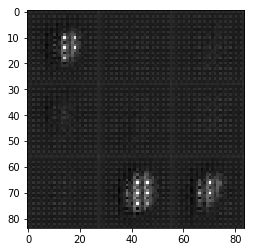

Epoch 1/2... Discriminator Loss: 1.0914... Generator Loss: 0.8118
Epoch 1/2... Discriminator Loss: 1.0658... Generator Loss: 1.6822
Epoch 1/2... Discriminator Loss: 1.0452... Generator Loss: 1.0010
Epoch 1/2... Discriminator Loss: 1.4232... Generator Loss: 1.5395
Epoch 1/2... Discriminator Loss: 1.2762... Generator Loss: 1.0569
Epoch 1/2... Discriminator Loss: 1.4405... Generator Loss: 1.2022
Epoch 1/2... Discriminator Loss: 1.3677... Generator Loss: 0.7965
Epoch 1/2... Discriminator Loss: 2.8334... Generator Loss: 2.9858
Epoch 1/2... Discriminator Loss: 3.0947... Generator Loss: 3.1273
Epoch 1/2... Discriminator Loss: 3.5611... Generator Loss: 3.3524


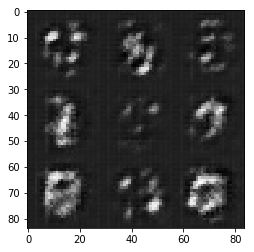

Epoch 1/2... Discriminator Loss: 2.7470... Generator Loss: 2.3104
Epoch 1/2... Discriminator Loss: 3.7800... Generator Loss: 3.3347
Epoch 1/2... Discriminator Loss: 2.0883... Generator Loss: 0.4719
Epoch 1/2... Discriminator Loss: 2.3334... Generator Loss: 0.4265
Epoch 1/2... Discriminator Loss: 2.8005... Generator Loss: 1.0261
Epoch 1/2... Discriminator Loss: 2.9092... Generator Loss: 0.7935
Epoch 1/2... Discriminator Loss: 2.7661... Generator Loss: 0.7006
Epoch 1/2... Discriminator Loss: 2.7949... Generator Loss: 0.7073
Epoch 1/2... Discriminator Loss: 2.8523... Generator Loss: 0.5515
Epoch 1/2... Discriminator Loss: 2.9927... Generator Loss: 0.5053


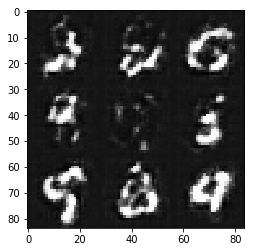

Epoch 1/2... Discriminator Loss: 3.1261... Generator Loss: 0.6074
Epoch 1/2... Discriminator Loss: 3.1354... Generator Loss: 0.6018
Epoch 1/2... Discriminator Loss: 3.1387... Generator Loss: 0.6492
Epoch 1/2... Discriminator Loss: 3.1998... Generator Loss: 0.4072
Epoch 1/2... Discriminator Loss: 3.2871... Generator Loss: 0.6937
Epoch 1/2... Discriminator Loss: 3.1873... Generator Loss: 0.5436
Epoch 1/2... Discriminator Loss: 3.4328... Generator Loss: 0.5997
Epoch 1/2... Discriminator Loss: 3.4583... Generator Loss: 0.6653
Epoch 1/2... Discriminator Loss: 3.5982... Generator Loss: 0.9608
Epoch 1/2... Discriminator Loss: 4.0673... Generator Loss: 1.3786


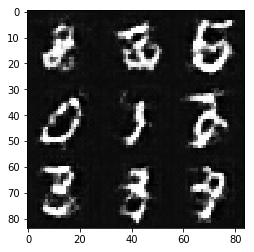

Epoch 2/2... Discriminator Loss: 4.2776... Generator Loss: 1.7102
Epoch 2/2... Discriminator Loss: 3.7231... Generator Loss: 1.1203
Epoch 2/2... Discriminator Loss: 4.5968... Generator Loss: 2.4002
Epoch 2/2... Discriminator Loss: 2.9279... Generator Loss: 0.5988
Epoch 2/2... Discriminator Loss: 4.2408... Generator Loss: 1.5554
Epoch 2/2... Discriminator Loss: 2.8845... Generator Loss: 0.4902
Epoch 2/2... Discriminator Loss: 3.8427... Generator Loss: 1.2987
Epoch 2/2... Discriminator Loss: 3.3123... Generator Loss: 0.5642
Epoch 2/2... Discriminator Loss: 4.4163... Generator Loss: 1.5631
Epoch 2/2... Discriminator Loss: 4.5694... Generator Loss: 2.2571


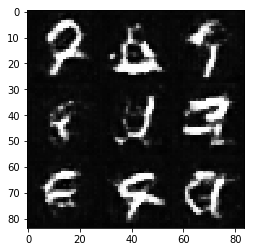

Epoch 2/2... Discriminator Loss: 3.6565... Generator Loss: 0.7994
Epoch 2/2... Discriminator Loss: 3.2359... Generator Loss: 0.5471
Epoch 2/2... Discriminator Loss: 4.6721... Generator Loss: 2.2652
Epoch 2/2... Discriminator Loss: 3.9977... Generator Loss: 0.9583
Epoch 2/2... Discriminator Loss: 3.5569... Generator Loss: 0.3747
Epoch 2/2... Discriminator Loss: 3.6477... Generator Loss: 0.4941
Epoch 2/2... Discriminator Loss: 3.8042... Generator Loss: 0.6225
Epoch 2/2... Discriminator Loss: 3.8989... Generator Loss: 0.8355
Epoch 2/2... Discriminator Loss: 3.6499... Generator Loss: 0.4065
Epoch 2/2... Discriminator Loss: 4.2138... Generator Loss: 1.1486


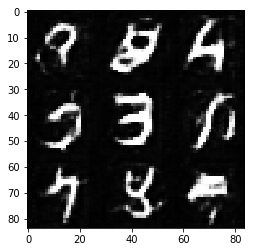

Epoch 2/2... Discriminator Loss: 3.7874... Generator Loss: 0.7736
Epoch 2/2... Discriminator Loss: 4.0246... Generator Loss: 0.9120
Epoch 2/2... Discriminator Loss: 4.4244... Generator Loss: 1.4394
Epoch 2/2... Discriminator Loss: 4.6897... Generator Loss: 1.8331
Epoch 2/2... Discriminator Loss: 4.4416... Generator Loss: 1.1737
Epoch 2/2... Discriminator Loss: 4.6065... Generator Loss: 1.5221
Epoch 2/2... Discriminator Loss: 4.4002... Generator Loss: 1.2860
Epoch 2/2... Discriminator Loss: 4.2596... Generator Loss: 0.9416
Epoch 2/2... Discriminator Loss: 4.3003... Generator Loss: 1.1903
Epoch 2/2... Discriminator Loss: 4.3056... Generator Loss: 1.3512


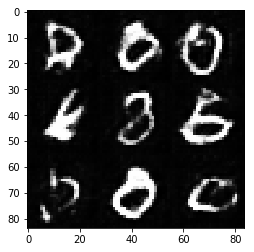

Epoch 2/2... Discriminator Loss: 4.0751... Generator Loss: 0.7316
Epoch 2/2... Discriminator Loss: 4.1884... Generator Loss: 1.1076
Epoch 2/2... Discriminator Loss: 3.9568... Generator Loss: 0.7191
Epoch 2/2... Discriminator Loss: 4.1301... Generator Loss: 0.9528
Epoch 2/2... Discriminator Loss: 4.6523... Generator Loss: 1.5233
Epoch 2/2... Discriminator Loss: 3.8863... Generator Loss: 0.4626
Epoch 2/2... Discriminator Loss: 4.5933... Generator Loss: 1.7404
Epoch 2/2... Discriminator Loss: 4.2568... Generator Loss: 0.9991
Epoch 2/2... Discriminator Loss: 4.0735... Generator Loss: 0.6461
Epoch 2/2... Discriminator Loss: 4.0703... Generator Loss: 0.2970


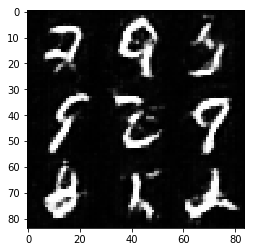

IndexError: list index out of range

In [46]:
batch_size = 150
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.2434... Generator Loss: 2.1101
Epoch 1/1... Discriminator Loss: 2.3870... Generator Loss: 0.4134
Epoch 1/1... Discriminator Loss: 1.8309... Generator Loss: 2.6236
Epoch 1/1... Discriminator Loss: 4.4305... Generator Loss: 0.1132
Epoch 1/1... Discriminator Loss: 1.7928... Generator Loss: 4.8289
Epoch 1/1... Discriminator Loss: 4.7922... Generator Loss: 0.0381
Epoch 1/1... Discriminator Loss: 2.1796... Generator Loss: 0.5295
Epoch 1/1... Discriminator Loss: 3.7678... Generator Loss: 5.3876
Epoch 1/1... Discriminator Loss: 3.4076... Generator Loss: 0.0823
Epoch 1/1... Discriminator Loss: 2.6505... Generator Loss: 2.4850


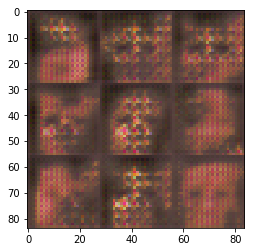

Epoch 1/1... Discriminator Loss: 1.8255... Generator Loss: 0.6646
Epoch 1/1... Discriminator Loss: 4.9052... Generator Loss: 0.0240
Epoch 1/1... Discriminator Loss: 2.2531... Generator Loss: 0.3190
Epoch 1/1... Discriminator Loss: 1.6585... Generator Loss: 0.8454
Epoch 1/1... Discriminator Loss: 1.8333... Generator Loss: 0.9497
Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.8369
Epoch 1/1... Discriminator Loss: 1.6656... Generator Loss: 0.4000
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 1.1661
Epoch 1/1... Discriminator Loss: 1.8246... Generator Loss: 1.4751
Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.5536


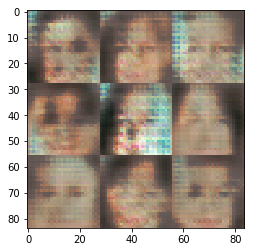

Epoch 1/1... Discriminator Loss: 2.1160... Generator Loss: 1.9289
Epoch 1/1... Discriminator Loss: 1.5814... Generator Loss: 1.1216
Epoch 1/1... Discriminator Loss: 2.8202... Generator Loss: 2.2634
Epoch 1/1... Discriminator Loss: 1.5352... Generator Loss: 0.6442
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.6991
Epoch 1/1... Discriminator Loss: 1.6349... Generator Loss: 0.4683
Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 0.9569
Epoch 1/1... Discriminator Loss: 1.2256... Generator Loss: 0.7463
Epoch 1/1... Discriminator Loss: 1.2617... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 1.1856


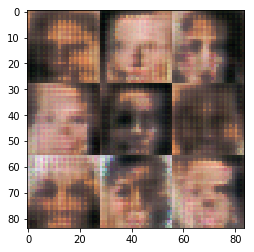

Epoch 1/1... Discriminator Loss: 1.6693... Generator Loss: 1.2270
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.7044
Epoch 1/1... Discriminator Loss: 1.0904... Generator Loss: 0.8227
Epoch 1/1... Discriminator Loss: 1.5899... Generator Loss: 0.7933
Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 0.5114
Epoch 1/1... Discriminator Loss: 1.4638... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 1.2757... Generator Loss: 0.7200
Epoch 1/1... Discriminator Loss: 1.5172... Generator Loss: 1.3415
Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 0.8308
Epoch 1/1... Discriminator Loss: 1.5729... Generator Loss: 1.5708


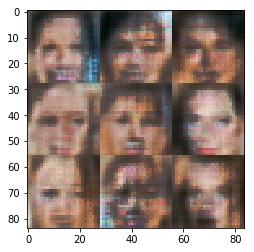

Epoch 1/1... Discriminator Loss: 1.3156... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.8384
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.8299
Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 1.6624... Generator Loss: 0.3418
Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 0.6728
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.7872
Epoch 1/1... Discriminator Loss: 1.5129... Generator Loss: 0.8987
Epoch 1/1... Discriminator Loss: 1.3188... Generator Loss: 0.6733


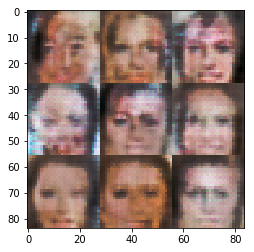

Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 1.5819... Generator Loss: 0.4806
Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.8440
Epoch 1/1... Discriminator Loss: 1.5954... Generator Loss: 0.5134
Epoch 1/1... Discriminator Loss: 1.2882... Generator Loss: 0.7166
Epoch 1/1... Discriminator Loss: 1.2566... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.7380
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.4624
Epoch 1/1... Discriminator Loss: 1.4663... Generator Loss: 0.9237
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 1.0051


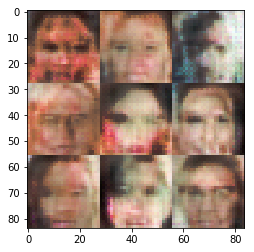

Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.6707
Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 0.8697
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 1.6271... Generator Loss: 1.3008
Epoch 1/1... Discriminator Loss: 1.2914... Generator Loss: 0.7189
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.7938
Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.8369
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.3329... Generator Loss: 0.9365
Epoch 1/1... Discriminator Loss: 1.5370... Generator Loss: 0.4729


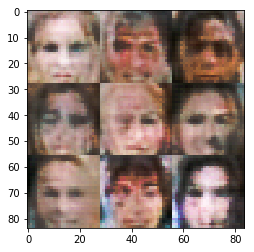

Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.8189
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.6383
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.8486
Epoch 1/1... Discriminator Loss: 1.4921... Generator Loss: 1.0202
Epoch 1/1... Discriminator Loss: 1.5790... Generator Loss: 0.4258
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.7083
Epoch 1/1... Discriminator Loss: 1.4813... Generator Loss: 0.4962
Epoch 1/1... Discriminator Loss: 1.5717... Generator Loss: 1.1192
Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 0.9556
Epoch 1/1... Discriminator Loss: 1.3540... Generator Loss: 0.7183


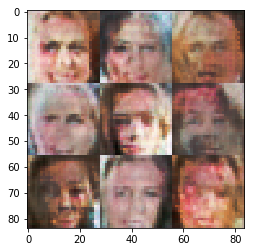

Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.6506
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.8811
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.6847
Epoch 1/1... Discriminator Loss: 1.4835... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.3229... Generator Loss: 0.6499
Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 0.5522
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.8147
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.5600
Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.6056


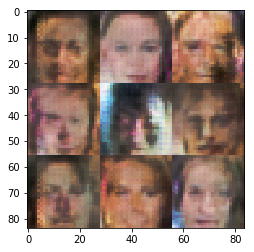

Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 1.5982... Generator Loss: 0.3546
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 1.0657
Epoch 1/1... Discriminator Loss: 1.5131... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 1.3560... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.7732
Epoch 1/1... Discriminator Loss: 1.3700... Generator Loss: 0.6145
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.8451
Epoch 1/1... Discriminator Loss: 1.2964... Generator Loss: 0.9246


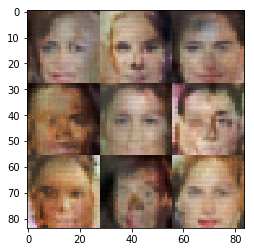

Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.7699
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.5855
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.6572
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.5793
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 1.0076
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.7189
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.7852


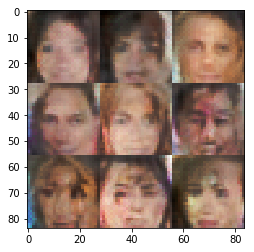

Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 0.8978
Epoch 1/1... Discriminator Loss: 1.3396... Generator Loss: 0.6762
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 1.0013
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.8100
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.5767
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.5140
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.9202
Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.6688
Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 0.8552


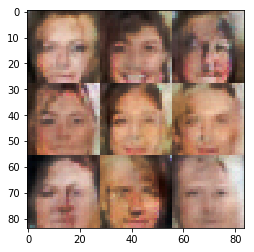

Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.9418
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.8461
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.6580
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.7925
Epoch 1/1... Discriminator Loss: 1.3374... Generator Loss: 0.9356
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 1.0620
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.5567
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.6731
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.5908
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 0.4784


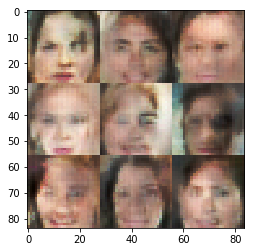

Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.6412
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.5485
Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 1.2483... Generator Loss: 0.8711
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.5083
Epoch 1/1... Discriminator Loss: 1.3569... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 0.7766
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.8751
Epoch 1/1... Discriminator Loss: 1.4913... Generator Loss: 1.0244
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.6494


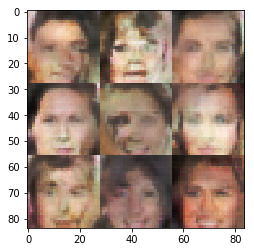

Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.6615
Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.8265
Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 0.5958
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.7084
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.5945
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.7305
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.7633
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.7060
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.8286


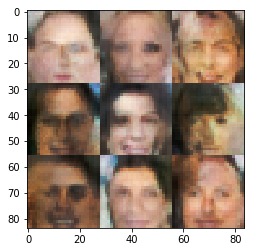

Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.6348
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.5624
Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.5322
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.8341
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.6528
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.6650
Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.9245
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.8599
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.9504


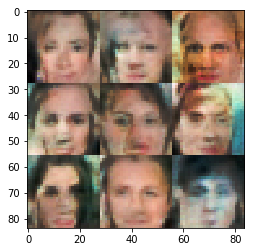

Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.6041
Epoch 1/1... Discriminator Loss: 1.5252... Generator Loss: 1.0222
Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 0.7419
Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.7068
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.8981
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.8613
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.8338
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.6348
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.8033


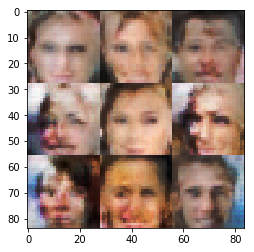

Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.7271
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.8083
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.8325
Epoch 1/1... Discriminator Loss: 1.4732... Generator Loss: 0.5090
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.8683
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.7558
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.6430
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.7184


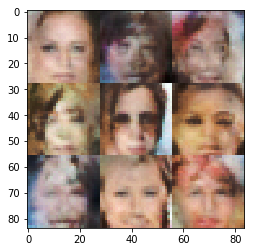

Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.8909
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.6580
Epoch 1/1... Discriminator Loss: 1.4468... Generator Loss: 0.4960
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.5759
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.6635
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.7352
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.8262
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.6424


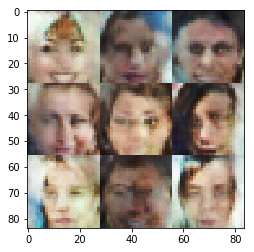

Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.9130
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.8850
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.6493
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.9213
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.6352
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.7612


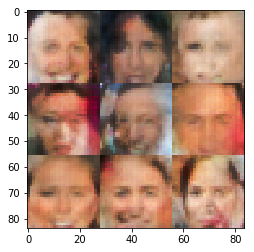

Epoch 1/1... Discriminator Loss: 1.4662... Generator Loss: 0.9966
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.7819


IndexError: list index out of range

In [47]:
batch_size = 100
z_dim = 100
learning_rate = 0.005
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.